<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/T5M2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

T5 we don't training again just use model from T4 to predict

Replace observational data with climate data

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set Output folder

In [49]:
import os
os.chdir('/content/drive/MyDrive/dynamic_comparison_all_models/')
outs=['save_model','save_pickles','tables','figs']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)

# Import Libraries

In [50]:
# Run functions
%run customize_functions.ipynb
# For tensorboard
from tensorflow.keras.callbacks import TensorBoard
import time
import seaborn as sns

# Tensorboard

In [51]:
%tensorflow_version 2.x
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [52]:
import tensorflow as tf
import datetime
# from lstm_utils import *
import pickle
from sklearn.preprocessing import MinMaxScaler
####LIBRARY
import scipy
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import Sequential

from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras # tai sao import tu tensorflow
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
####################################################
import datetime
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import datetime

# import statsmodels as sm
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib
###  SET FONTS FOR PLOTTING
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
### cap nhat font
# plt.rcParams.update({'font.size': 14})

####RANDOM SEED SET
#tf.random.set_seed(10000000)
#np.random.seed(10000000)

####PANDAS LIB
from pandas import DataFrame
from pandas import concat
###### Univrate LSTM
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
######## Keras tunner
# import keras_tuner as kt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
def series_to_supervised_df(data, n_in, n_out, dropnan=True): # dung cho pandas
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # 
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i)) 
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Load data and initial paramaters

In [53]:
# Ten mo hinh

# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)

# load du lieu tu mo hinh khi hau
with open('input_pickles'+'/'+'list_PRS_NDIclim_all.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59cli = pickle.load(f2) # co 3 buoc du bao M1, M2, M3
    

# Define station, lag, lead times

/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


(350, 1, 15)


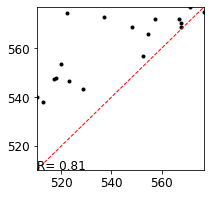

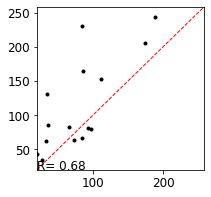

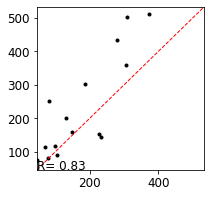

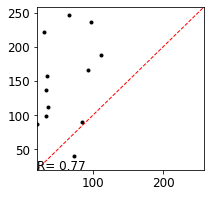

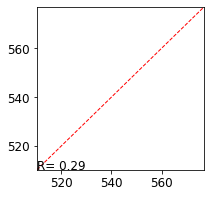

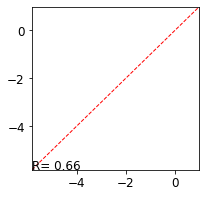

In [54]:


###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names0=['T4M1','T4M2','T4M3'] # CAI NAY DE MO FILE CU
names=['T5M1','T5M2','T5M3'] # CAI NAY DE LUU KET QUA MOI

k=29 # chi so thu tu cua tram ganghwa
n_in0=3
n_out0=2 # gia tri lead time du bao
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df1=df0.iloc[:(2016-1968+1)*12,:]
# df1=df0 # du bao het
# df1a: la du lieu tu mo hinh khi hau
df1a=PRS3_NDI3_59cli[n_out0-2][k] # tuong ung lead time =1
df1b=PRS3_NDI3_59cli[n_out0-1][k] # tuong ung voi lead time =2
# =============================================================================

# =============================================================================

df2=series_to_supervised_df(df1,n_in0,n_out0)
# df2a: cung phai chia gia tri mo hinh khi hau theo thuc do
df2a=series_to_supervised_df(df1a,n_in0,n_out0) # van phai chia thanh 2 gan gia tri cho t
df2b=series_to_supervised_df(df1b,n_in0,n_out0) # lead time bang 2 gan gia tri cho t+1

# =============================================================================
# =============================================================================
#     remove values PRS  at fure prediction
# var3(t),var2(t),var1(t) have to remove
list_drops=[np.arange(2,5)*-1,np.arange(2,9)*-1,np.arange(2,13)*-1]
list_drops1=[[],[],[]]
list_drops1a=[[-5,-9,-13],[-5,-9,-13,-17],[-5,-9,-13,-17,-21]]


# =============================================================================
df3=df2.drop(df2.columns[[list_drops1[n_out0-1]]],axis=1)
df4obs=df3.drop(df3.columns[[list_drops1a[n_out0-1]]],axis=1)
df4climtemp=df4obs # bien tam thoi trung gian cho khi hau de lay du lieu tu khi hau qua
# =============================================================================
# # IMPORTANT: REPLACE VALUES OF VAR1, VAR2,VAR3 AT T BY CLIMATE VALUE
## PHAI THAY TU NAM 2016.12  QUAY NGUOC LAI
# =============================================================================
df4climtemp.iloc[-df2a.shape[0]:,[-2,-3,-4]]=df2b.iloc[:,[-2,-3,-4]] # gan gia tri tai buoc t+1
# Da bo NDI nen cac gia tri PRS phia truoc la lien tuc
df4climtemp.iloc[-df2a.shape[0]:,[-7,-6,-5]]=df2a.iloc[:,[-8,-7,-6]] # gan gia tri tai buoc t
df4=df4climtemp


# ve hinh Kiem tra gia tri tai vi tri thay the
# df4obs.iloc[-df2a.shape[0]:,[-2,-3,-4]].plot(kind='line')
# df4.iloc[-df2a.shape[0]:,[-2,-3,-4]].plot(kind='line')
df_error=pd.concat([df3.iloc[-df2a.shape[0]:,[-2,-3,-4]],df4.iloc[-df2a.shape[0]:,[-2,-3,-4]]],axis=1)
df_error.columns=['Sobs','Robs','Pobs','Scli','Rcli','Pcli']
pearson,dotincay=pearsonr(df_error['Sobs'],df_error['Scli'])
min_values=np.min(df_error['Sobs'])
max_values=np.max(df_error['Sobs'])

r2_vanila_1m =pearson
fig,ax=plt.subplots(figsize=(3,3))
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=df_error['Sobs'],
            y=df_error['Scli'],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None) 
# text
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
# duong 45
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

# Runoff
pearson,dotincay=pearsonr(df_error['Robs'],df_error['Rcli'])
min_values=np.min(df_error['Robs'])
max_values=np.max(df_error['Robs'])

r2_vanila_1m =pearson
fig,ax=plt.subplots(figsize=(3,3))
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=df_error['Robs'],
            y=df_error['Rcli'],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None) 
# text
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
# duong 45
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

# Pre
pearson,dotincay=pearsonr(df_error['Pobs'],df_error['Pcli'])
min_values=np.min(df_error['Pobs'])
max_values=np.max(df_error['Pobs'])

r2_vanila_1m =pearson
fig,ax=plt.subplots(figsize=(3,3))
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=df_error['Pobs'],
            y=df_error['Pcli'],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None) 
# text
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
# duong 45
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)
# Sai so cho buoc t+2**********************************************************************************************
######################
# df4.iloc[-df2a.shape[0]:,[-2,-3,-4]].plot(kind='line')
df_error=pd.concat([df3.iloc[-df2a.shape[0]:,[-7,-6,-5]],df4.iloc[-df2a.shape[0]:,[-7,-6,-5]]],axis=1)
df_error.columns=['Sobs','Robs','Pobs','Scli','Rcli','Pcli']
pearson,dotincay=pearsonr(df_error['Sobs'],df_error['Scli'])
min_values=np.min(df_error['Sobs'])
max_values=np.max(df_error['Sobs'])

r2_vanila_1m =pearson
fig,ax=plt.subplots(figsize=(3,3))
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=df_error['Sobs'],
            y=df_error['Scli'],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None) 
# text
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
# duong 45
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

# Runoff
pearson,dotincay=pearsonr(df_error['Robs'],df_error['Rcli'])
min_values=np.min(df_error['Robs'])
max_values=np.max(df_error['Robs'])

r2_vanila_1m =pearson
fig,ax=plt.subplots(figsize=(3,3))
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=df_error['Robs'],
            y=df_error['Rcli'],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None) 
# text
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
# duong 45
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

# Pre
pearson,dotincay=pearsonr(df_error['Pobs'],df_error['Pcli'])
min_values=np.min(df_error['Pobs'])
max_values=np.max(df_error['Pobs'])

r2_vanila_1m =pearson
fig,ax=plt.subplots(figsize=(3,3))
plt.xlim(min_values,max_values)
plt.ylim(min_values,max_values)

plt.scatter(x=df_error['Pobs'],
            y=df_error['Pcli'],
            s=None,
            c='k', 
            marker='.', 
            cmap=None,
            norm=None,
            vmin=None, 
            vmax=None,
            alpha=None,            
            linewidths=None,
            edgecolors=None,plotnonfinite=False,data=None) 
# text
plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
# duong 45
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)


####################
# =============================================================================


# Chia du lieu theo ti le 6:3:3
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df0=df4.iloc[n_train+n_val:,:] # ORG
# chi lay test dung so lieu cua khi hau
test_df=test_df0.iloc[-df2a.shape[0]:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# x_val,y_val0=val_df.iloc[:,:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO

y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
# n_features=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

# TH2: xem no nhu 12 dac tinh
n_step=1
train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
print(train_X.shape)


# Define model and setup training, save models


In [ ]:
# # dinh nghia lai loss function, cai nay optimize kem
# tf.keras.backend.clear_session()
# mape = tf.keras.losses.MeanAbsolutePercentageError()
# # =============================================================================
## KHONG CHAY NUA NE KHOA LAI CHO CHAC
# # =============================================================================
# # =============================================================================
# # Define model
# model = Sequential()
# # # TH1 : xem 12 gia tri la buoc thoi gian
# # model.add(LSTM(256,activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))

# # TH2 : xem 12 gia tri la dac tinh
# model.add(LSTM(128,activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# # opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.0)
# model.compile(optimizer=opt, loss='mse')
# model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72192     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 72,321
Trainable params: 72,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### KHONG CHAY NUA NEN KHOA LAI CHO CHAC

# ###############################################################################
# # NAME="T4-M1-TB-{}".format(int(time.time()))
# NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# # tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# # path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# # tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
# tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
#                                                      histogram_freq=1) # ket hop 
# # conditional call back
# value00=0.0045 # cho validation
# from keras.callbacks import Callback
# class EarlyStoppingByLossVal(Callback):
#     def __init__(self, monitor='val_loss', value=value00, verbose=0):
#         super(Callback, self).__init__()
#         self.monitor = monitor
#         self.value = value
#         self.verbose = verbose

#     def on_epoch_end(self, epoch, logs={}):
#         current = logs.get(self.monitor)
#         if current is None:
#             warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

#         if current < self.value:
#             if self.verbose > 0:
#                 print("Epoch %05d: early stopping THR" % epoch)
#             self.model.stop_training = True

# callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

# ###############
# # condtion for training
# # conditional call back
# value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
# from keras.callbacks import Callback
# class EarlyStoppingByLoss(Callback):
#     def __init__(self, monitor='loss', value=value0, verbose=0):
#         super(Callback, self).__init__()
#         self.monitor = monitor
#         self.value = value
#         self.verbose = verbose

#     def on_epoch_end(self, epoch, logs={}):
#         current = logs.get(self.monitor)
#         if current is None:
#             warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

#         if current < self.value:
#             if self.verbose > 0:
#                 print("Epoch %05d: early stopping THR" % epoch)
#             self.model.stop_training = True

# callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
# ##### callbacks
# callbacks_list = [
# # callbacks_threshole_val,
# #  # stopping
# keras.callbacks.EarlyStopping(
# monitor="val_loss",
# patience=300,
# mode="min",
# ),

# ###################################################################

# # checkpoint
# keras.callbacks.ModelCheckpoint(
# filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stop.keras", # cong them buoc thoi gian
# monitor="val_loss",
# save_best_only=True,
# ),
# # tensorboard,
# tensorboard_callback1,
# ]
# ######################################################################


# TRAINING MODELS

In [ ]:
## KHONG CHAY NUA NEN KHOA LAI
# # set seed de ket qua model khong bi thay doi
# seed=123456789
# import random
# # import numpy as np
# # import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)

# # Fit model can bo sung them batchsize

# history1=model.fit(train_X,
#           y_train_scale,
# epochs=1500,
# callbacks=callbacks_list,
# validation_data=(val_X,y_val_scale),
# batch_size=36,sample_weight=None,
# steps_per_epoch=12,
# initial_epoch=10,
# )



Epoch 11/1500
12/12 [==============================] - 3s 73ms/step - loss: 0.2218 - val_loss: 0.1802
Epoch 12/1500
12/12 [==============================] - 0s 12ms/step - loss: 0.1196 - val_loss: 0.0827
Epoch 13/1500
12/12 [==============================] - 0s 13ms/step - loss: 0.0563 - val_loss: 0.0421
Epoch 14/1500
12/12 [==============================] - 0s 13ms/step - loss: 0.0412 - val_loss: 0.0407
Epoch 15/1500
12/12 [==============================] - 0s 13ms/step - loss: 0.0376 - val_loss: 0.0346
Epoch 16/1500
12/12 [==============================] - 0s 11ms/step - loss: 0.0345 - val_loss: 0.0314
Epoch 17/1500
12/12 [==============================] - 0s 12ms/step - loss: 0.0326 - val_loss: 0.0288
Epoch 18/1500
12/12 [==============================] - 0s 12ms/step - loss: 0.0310 - val_loss: 0.0264
Epoch 19/1500
12/12 [==============================] - 0s 11ms/step - loss: 0.0290 - val_loss: 0.0249
Epoch 20/1500
12/12 [==============================] - 0s 12ms/step - loss: 0.0279

# Load results

In [55]:

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names0[n_out0-1]+str(k)+"lead"+str(m)+"best_stop.keras")
print("Loaded model from disk")


Loaded model from disk


# Draw graphics

<Figure size 432x288 with 0 Axes>

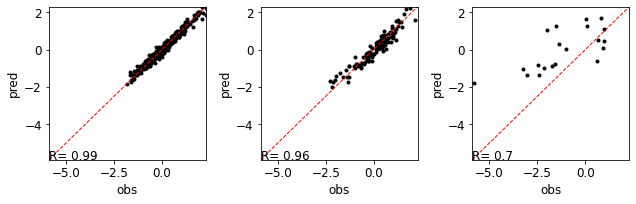

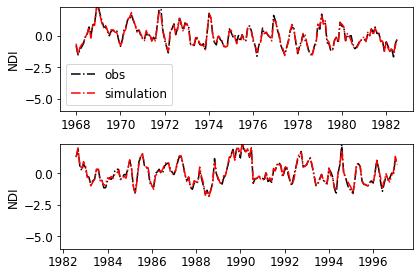

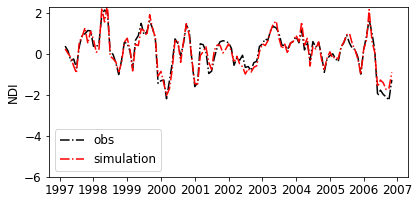

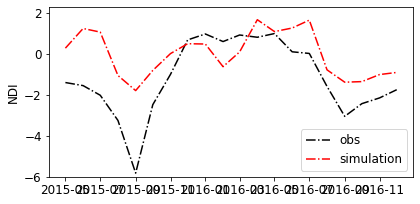

In [56]:

# =============================================================================
# DANH GIA
# =============================================================================
# # TONG KET 
# # DRAW LOSS CURVE
# #Check the Loss curve
# fig,ax=plt.subplots(figsize=(6,3))
# plt.rcParams.update({'font.size': 11})
# plt.plot(history1.history['loss'])
# plt.plot(history1.history['val_loss'])
# # Draw the minimum epochs 
# df_val_loss=pd.DataFrame({'val_loss':history1.history['val_loss']})
# # print(df_val_loss)
# idxmin=df_val_loss[['val_loss']].idxmin().values
# val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
# print(idxmin,val_loss_min_values)
# plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
#              xy=(idxmin,val_loss_min_values), xycoords='data',
#             xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )

# plt.legend(['train','val'])
# plt.xlabel('epochs')
# plt.ylabel('mse')
# # plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period

y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2
  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0]+str(k)+'train_time_T3'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+names[n_out0]+str(k)+'train_time_T3'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T3'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

#   # TEST*************************************************************************
  
# #Graph
# months=['1month','2months','3months']
# for lead_time in range(1):
#   fig,ax=plt.subplots(figsize=(6,3))
#   plt.subplot(111)
#   plt.rcParams.update({'font.size': 12})
#   plt.ylim([-6.0,2.3])
#   vector_date_test=vector_date[-24:]
#   plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
#   plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
#     # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
#   plt.legend(['obs','simulation'])

#   plt.ylabel('NDI')
#   # plt.title('Time series '+'1month' +' lead time prediction at testing')
#   plt.tight_layout() 

#   plt.savefig(outs[3]+'/'+str(k)+'test_time_T4'+str(m)+'.jpeg',dpi=300)
#   plt.show()
#   plt.close()
# =============================================================================

# TEST*************************************************************************
  # Chi plot 2015-2016
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  # vector_date_test=vector_date[-24:]
  n_test_plot=len(pred3)
  vector_date_test=vector_date[-n_test_plot:]
  plt.plot(vector_date[-n_test_plot:],obs3[-n_test_plot:],'k-.')
  plt.plot(vector_date[-n_test_plot:],pred3[-n_test_plot:],'r-.')
    # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1month' +' lead time prediction at testing')
  plt.tight_layout() 

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T4'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================


# Save result to CSV

In [ ]:
  
      # compressed_file = bz2.BZ2File(f, 'w')
m=0

# 0: train, #1: val, # 2:test
# list_con[2].iloc[-24:,:].to_csv(outs[2]+'/'+'T4-'+str(m+1)+'.csv')

In [ ]:
# ## enable to see data franame
# %load_ext google.colab.data_table
# df_test


In [ ]:


# ## diable to see dataframe
# %unload_ext google.colab.data_table

In [ ]:
# %tensorboard --logdir logs/T4-M1-TB-2021/

In [ ]:
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

In [ ]:
# # Control TensorBoard display. If no port is provided, 
# # the most recently launched TensorBoard is used
# notebook.display(port=13042, height=1000) 